# CNN training

In [140]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

Tensorflow version 2.2.0


In [1]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

NameError: name 'os' is not defined

# Functions

In [74]:
def showDateTime():
    time_stamp = datetime.datetime.now()
    print(time_stamp.strftime('%Y.%m.%d-%H:%M:%S'))

In [5]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [57]:
def output_to_file(results,file_name):
#    path = os.getcwd() 
    path = os.path.dirname(file_name)

    if not os.path.exists(path):
        os.mkdir(path)

#    file_name = path + '/' + file_name
    fp = open(file_name,'w')
    if type(results) == list:
        for result_line in results:
            if type(result_line) != list:
                fp.write(str(result_line))
            else:
                for each_one in result_line:
                    fp.write(str(each_one))
                    fp.write('\t')
            fp.write('\n')

    elif type(results) == dict:
        for key in results.keys():
            for result_line in results[key]:
                for each_one in result_line:
                    fp.write(str(each_one))
                    fp.write('\t')
                fp.write('\n')
    elif type(results) == np.ndarray:
        np.savetxt(file_name, results, fmt='%s', delimiter='\t')
    else:
        print ('unsupport results type!')
    print ('The variable has already output to %s'%file_name)
    fp.close()

In [6]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [7]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [8]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

In [9]:
def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))

#ref: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [201]:
def cnn_model(model_name, nClasses):
    if model_name == "CNN_model":
        model = Sequential()
        # The first two layers with 32 filters of window size 3x3
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nClasses, activation='softmax'))
        
        #opt = keras.optimizers.Adam(learning_rate=0.01)
        #The learning rate. Defaults to 0.001
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=['accuracy', f1_m, precision_m, recall_m])
        return model
    
    elif model_name == "MobileNet_v1":
        model = tf.keras.applications.MobileNet(
                    input_shape=None,
                    alpha=1.0,
                    depth_multiplier=1,
                    dropout=0.001,
                    include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    pooling=None,
                    classes=1000,
                    classifier_activation="softmax"
                )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
        return new_model
    
    elif model_name == 'ResNet50':
        model = tf.keras.applications.ResNet50(
                include_top=True,
                weights="imagenet",
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000
            )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
        return new_model
    
    else:
        print("[Error] No this model%s:"%model_name)
        pdb.set_trace()

In [11]:
def pred_roc_data(model, img, label_one_hot):
    pred_keras = model.predict(img).ravel() # ravel(): Flatten the array
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_one_hot.ravel(), pred_keras, drop_intermediate=False) 
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, thresholds_keras, auc_keras

In [66]:
def output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file):
    model_metric_list = []
    model_metric_list.append(model_name)
    model_metric_list.append(["loss:", loss]) 
    model_metric_list.append(["accuracy:", accuracy])
    model_metric_list.append(["precision:", precision])
    model_metric_list.append(["recall:", recall])
    model_metric_list.append(["f1_score:", f1_score])
    output_to_file(model_metric_list, output_file)

# Processing

In [12]:
img_width, img_height = 224, 224

- For two classes

In [ ]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

In [ ]:
# true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [ ]:
# true_images_path_list  = true_cnv_df['image_path']
# false_images_path_list = false_cnv_df['image_path']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

- For three classes

In [13]:
# ## For rare CNVs
path = '/home/rt2776/cnv_espresso/images_rare_3classes/'
true_del_file  = path + 'true_del_image_info.list'
false_del_file = path + 'false_del_image_info.list'

true_dup_file  = path + 'true_dup_image_info.list'
false_dup_file = path + 'false_dup_image_info.list'

# ## For splited rare CNVs

In [14]:
true_del_df  = pd.read_csv(true_del_file,  header=0,sep='\t')
false_del_df = pd.read_csv(false_del_file, header=0,sep='\t')

true_dup_df  = pd.read_csv(true_dup_file,  header=0,sep='\t')
false_dup_df = pd.read_csv(false_dup_file, header=0,sep='\t')

In [15]:
true_del_images_path_list  = true_del_df['image_path']
false_del_images_path_list = false_del_df['image_path']

true_dup_images_path_list  = true_dup_df['image_path']
false_dup_images_path_list = false_dup_df['image_path']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

In [ ]:
true_del_images_path_list.shape, false_del_images_path_list.shape, true_dup_images_path_list.shape, false_dup_images_path_list.shape

### Loading images from list to numpy array

In [ ]:
true_del_img_np = loadImgs(true_del_images_path_list, img_width, img_height)
true_del_img_np.shape

In [ ]:
false_del_img_np = loadImgs(false_del_images_path_list, img_width, img_height)
false_del_img_np.shape

In [ ]:
true_dup_img_np = loadImgs(true_dup_images_path_list, img_width, img_height)
true_dup_img_np.shape

In [ ]:
false_dup_img_np = loadImgs(false_dup_images_path_list, img_width, img_height)
false_dup_img_np.shape

### Generage labels

In [ ]:
# Four classes
true_del_label = [0 for i in range(0,len(true_del_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]

true_dup_label = [3 for i in range(0,len(true_dup_img_np))]
false_dup_label = [2 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

In [ ]:
# Three classes
true_del_label = [0 for i in range(0,len(true_del_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]

true_dup_label = [2 for i in range(0,len(true_dup_img_np))]
false_dup_label = [1 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

### Combine true & false data

In [ ]:
combined_cnv_info_df = true_del_df.append(false_del_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(true_dup_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(false_dup_df, ignore_index=True)

In [ ]:
combined_img_np = np.vstack((true_del_img_np, false_del_img_np, true_dup_img_np, false_dup_img_np))

In [ ]:
combined_img_np.shape

In [ ]:
combined_label = true_del_label + false_del_label + true_dup_label + false_dup_label

In [ ]:
len(combined_label)

### Backup or restore

In [16]:
backup_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

In [ ]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

project_name = 'rare_entire_cnv'
combined_cnv_info_df.to_csv(backup_path+'rare_entire_cnv_info.csv')
np.save(backup_path+'rare_entire_cnv_img', combined_img_np)
np.save(backup_path+'rare_entire_cnv_label_'+str(len(np.unique(combined_label)))+'classes', combined_label)

In [ ]:
## Restore for entire del or dup

# project_name = 'rare_entire_del'
# project_name = 'rare_entire_dup'
project_name = 'rare_entire_cnv'
nClasses = 3
if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup' or project_name == 'rare_entire_cnv':
    combined_img_np = np.load(backup_path + project_name + '_img.npy')
    combined_label = np.load(backup_path+'rare_entire_cnv_label_'+str(nClasses)+'classes'+ '.npy')
    combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [ ]:
## Restore for split del or dup

# project_name = 'rare_split_del'
# project_name = 'rare_split_dup'

# if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
#     combined_img_np = np.load(backup_path + project_name + '_img.npy')
#     combined_label  = np.load(backup_path + project_name + '_label.npy')
#     try:
#         del combined_cnv_info_df
#     except:
#         pass

In [23]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img_np.shape)
print("  -- Shape of label      : ", combined_label.shape)
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_entire_cnv' dataset loaded.
  -- Shape of image array:  (22008, 224, 224, 3)
  -- Shape of label      :  (22008,)
  -- Shape of CNV info   :  (22008, 22)


### Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

## Normalization

In [25]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [26]:
# Change to float datatype
combined_img = combined_img_np.astype('float32')
# train_img = train_img.astype('float32')
# val_img   = val_img.astype('float32')
# test_img  = test_img.astype('float32')

# Scale the data to lie between 0 to 1
combined_img /= 255
# train_img /= 255
# val_img   /= 255
# test_img  /= 255

# Change the labels from integer to categorical data
combined_label_one_hot = to_categorical(combined_label)
# train_labels_one_hot = to_categorical(train_label)
# val_labels_one_hot   = to_categorical(val_label)
# test_labels_one_hot  = to_categorical(test_label)

In [28]:
# Find the unique numbers from the train labels
classes = np.unique(combined_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

Total number of outputs :  3
Output classes :  [0 1 2]
4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


In [ ]:
#np.where(train_label==0)

1


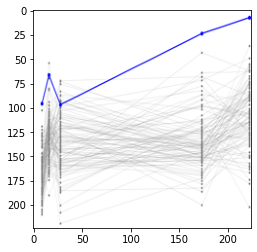

In [29]:
item = 100 
item = random.randint(0,len(combined_label))
print(combined_label[item])
showImg(combined_img[item])

## Split dataset into training(80%) and testing(20%) dataset

In [30]:
## split image arrays
if project_name == 'rare_entire_cnv' or project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img_np,
                                                                                                        combined_label_one_hot,
                                                                                                        combined_cnv_info_df,
                                                                                                        test_size=0.2,
                                                                                                        shuffle=True,
                                                                                                        random_state=3)

    train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                      train_label,
                                                                                                      train_cnv_info_df,
                                                                                                      test_size=0.25,
                                                                                                      shuffle=True,
                                                                                                      random_state=3) # 0.25*0.8=0.2

In [31]:
combined_img_np.shape, train_img.shape, val_img.shape, test_img.shape

((22008, 224, 224, 3),
 (13204, 224, 224, 3),
 (4402, 224, 224, 3),
 (4402, 224, 224, 3))

In [32]:
combined_label_one_hot.shape, train_label.shape, val_label.shape, test_label.shape

((22008, 3), (13204, 3), (4402, 3), (4402, 3))

In [33]:
## split image arrays for splits CNVs
if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
    train_img, test_img, train_label, test_label = train_test_split(combined_img_np,
                                                                    combined_label,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=3)

    train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                                  train_label,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=3) # 0.25*0.8=0.2

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


(None,
 array([0., 0., 1.], dtype=float32),
 Unnamed: 0                                                                 10726
 CHR                                                                           12
 PRED_START                                                              52301814
 PRED_END                                                                52385585
 TYPE                                                                         DUP
 SAMPLE                                                                 SP0060869
 CANOES_RT                                                                      1
 CLAMMS_RT                                                                      1
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                3
 RD_PROP_RT                                                                  2.25
 GC                                                   

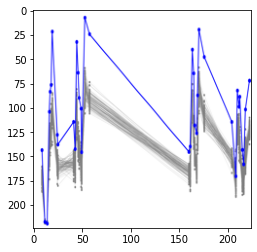

In [34]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
showImg(combined_img_np[i]),combined_label_one_hot[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


(None,
 array([0., 0., 1.], dtype=float32),
 Unnamed: 0                                                                  7087
 CHR                                                                            9
 PRED_START                                                             137106124
 PRED_END                                                               137114713
 TYPE                                                                         DUP
 SAMPLE                                                                 SP0015363
 CANOES_RT                                                                      1
 CLAMMS_RT                                                                   0.88
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                3
 RD_PROP_RT                                                                  1.69
 GC                                                   

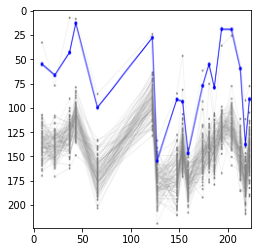

In [35]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
showImg(train_img[i]),train_label[i],train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]

In [36]:
test_img.shape, test_label.shape

((4402, 224, 224, 3), (4402, 3))

### Train the deep nerual model by Hold-out validation
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

In [52]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'

In [59]:
model_name='CNN_model'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()

Model name: CNN_model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None

In [61]:
print("Training by a common CNN model ...")
batch_size = 30
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Training by a common CNN model ...
Epoch 1/50
441/441 [==============================] - ETA: 0s - loss: 4.7040 - accuracy: 0.5665 - f1_m: 0.5156 - precision_m: 0.5881 - recall_m: 0.4766
Epoch 00001: val_accuracy improved from -inf to 0.77669, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_CNN_model_3classes.h5
441/441 [==============================] - 121s 274ms/step - loss: 4.7040 - accuracy: 0.5665 - f1_m: 0.5156 - precision_m: 0.5881 - recall_m: 0.4766 - val_loss: 0.4923 - val_accuracy: 0.7767 - val_f1_m: 0.7750 - val_precision_m: 0.7967 - val_recall_m: 0.7553
Epoch 2/50
440/441 [============================>.] - ETA: 0s - loss: 0.4583 - accuracy: 0.8154 - f1_m: 0.8123 - precision_m: 0.8273 - recall_m: 0.7986
Epoch 00002: val_accuracy improved from 0.77669 to 0.84507, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_CNN_model_3classes.h5
441/441 [==============================] 

In [72]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)

The variable has already output to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/model_metrics_ResNet50.txt


- MobileNet v1

In [76]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()
showDateTime()

Model name: MobileNet_v1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1539      
Total params: 4,767,915
Trainable params: 4,746,027
Non-trainable params: 21,888
_________________________________________________________________
2021.02.09-07:34:33


In [77]:
print("Training by MobileNet_v1 model ...")
batch_size = 60
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Training by MobileNet_v1 model ...
Epoch 1/50
221/221 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8359 - f1_m: 0.7968 - precision_m: 0.8212 - recall_m: 0.7850
Epoch 00001: val_accuracy improved from -inf to 0.83439, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5
221/221 [==============================] - 80s 360ms/step - loss: 0.4871 - accuracy: 0.8359 - f1_m: 0.7968 - precision_m: 0.8212 - recall_m: 0.7850 - val_loss: 0.5440 - val_accuracy: 0.8344 - val_f1_m: 0.8343 - val_precision_m: 0.8388 - val_recall_m: 0.8299
Epoch 2/50
220/221 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8742 - f1_m: 0.8738 - precision_m: 0.8789 - recall_m: 0.8688
Epoch 00002: val_accuracy did not improve from 0.83439
221/221 [==============================] - 76s 344ms/step - loss: 0.3381 - accuracy: 0.8743 - f1_m: 0.8743 - precision_m: 0.8795 - recall_m: 0.8694 - val_loss: 2.7813

In [78]:
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Model_name: MobileNet_v1
loss: 0.6956106424331665 
accuracy: 0.870059072971344 
f1_score: 0.8695903420448303 
precision: 0.8695904016494751 
recall: 0.8695904016494751


In [79]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)
showDateTime()

The variable has already output to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/model_metrics_MobileNet_v1.txt
2021.02.09-08:17:13


- ResNet 50

In [63]:
model_name='ResNet50'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()

Model name: ResNet50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 26,150,763
Trainable params: 26,097,643
Non-trainable params: 53,120
_________________________________________________________________


In [64]:
print("Training by ResNet50 model ...")
batch_size = 20
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
                     
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Training by ResNet50 model ...
Epoch 1/50
661/661 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7684 - f1_m: 0.7090 - precision_m: 0.8039 - recall_m: 0.6807
Epoch 00001: val_accuracy improved from -inf to 0.83576, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_ResNet50_3classes.h5
661/661 [==============================] - 174s 263ms/step - loss: 0.5641 - accuracy: 0.7684 - f1_m: 0.7090 - precision_m: 0.8039 - recall_m: 0.6807 - val_loss: 0.4257 - val_accuracy: 0.8358 - val_f1_m: 0.8370 - val_precision_m: 0.8484 - val_recall_m: 0.8265
Epoch 2/50
661/661 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8736 - f1_m: 0.8736 - precision_m: 0.8768 - recall_m: 0.8705
Epoch 00002: val_accuracy did not improve from 0.83576
661/661 [==============================] - 143s 217ms/step - loss: 0.3291 - accuracy: 0.8736 - f1_m: 0.8736 - precision_m: 0.8768 - recall_m: 0.8705 - val_loss: 3.6567 - val

In [65]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)

The variable has already output to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/model_metrics_ResNet50.txt


Text(0.5, 1.0, 'Loss Curves')

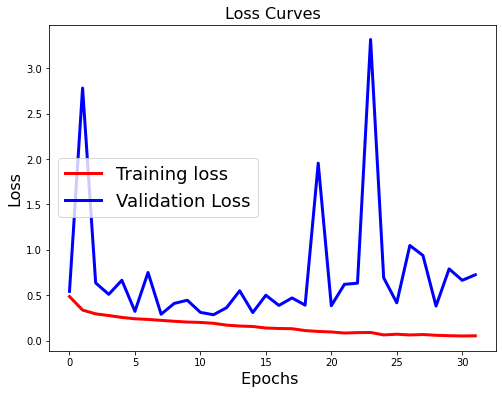

In [80]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'rare_entire_cnv accuracy curves')

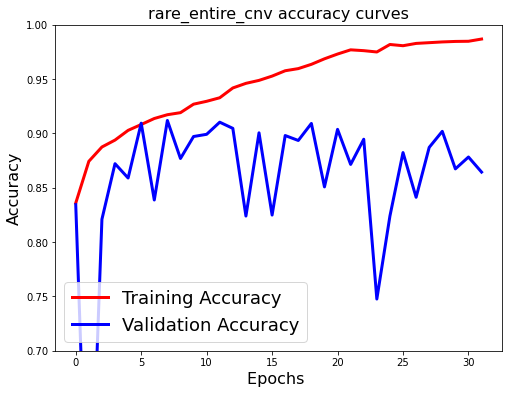

In [81]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim(0.7, 1)
plt.title(project_name+' accuracy curves',fontsize=16)

### ROC curve

In [82]:
print(project_name, model_name)
model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

rare_entire_cnv MobileNet_v1


'/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5'

In [87]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

Loading CNN_model ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_CNN_model_3classes.h5
Loading MobileNet_v1 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes.h5
Loading ResNet50 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_ResNet50_3classes.h5


In [88]:
fpr_MobileNet, tpr_MobileNet, thresholds_MobileNet, auc_MobileNet = pred_roc_data(MobileNet_model, test_img, test_label)
fpr_ResNet50,  tpr_ResNet50,  thresholds_ResNet50,  auc_ResNet50  = pred_roc_data(ResNet50_model,  test_img, test_label)
fpr_common_cnn,tpr_common_cnn,thresholds_common_cnn,auc_common_cnn= pred_roc_data(common_cnn_model,test_img, test_label)

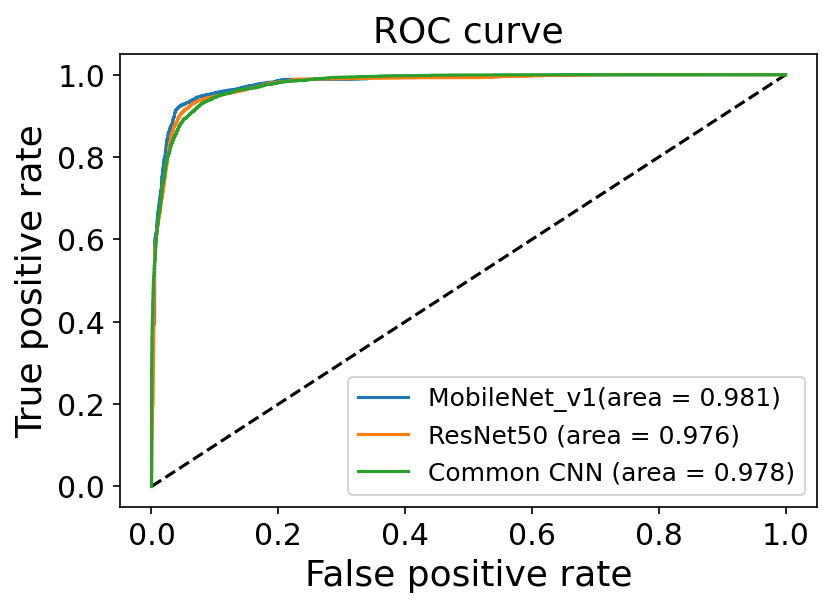

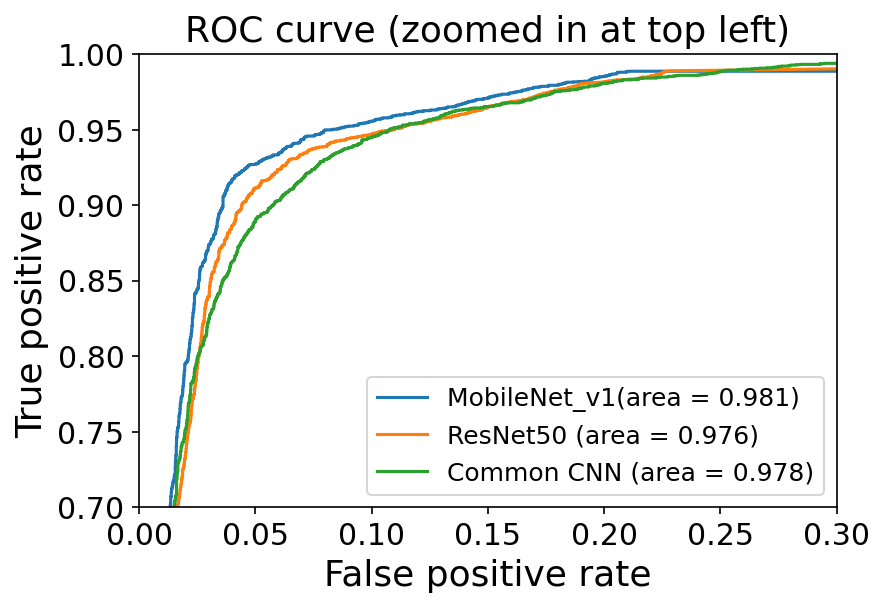

In [89]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2,dpi=150)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

- Calculate model metrics (F1-score). TODO: calcualte f1-score in different categories

In [134]:
print("Model_name: common_cnn_model")
loss, accuracy, f1_score, precision, recall = common_cnn_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Model_name: common_cnn_model
138/138 [==============================] - 5s 40ms/step - loss: 0.2850 - accuracy: 0.8944 - f1_m: 0.8947 - precision_m: 0.8972 - recall_m: 0.8923
loss: 0.28497031331062317 
accuracy: 0.8943662047386169 
f1_score: 0.8946971893310547 
precision: 0.8971610069274902 
recall: 0.8923107385635376


In [131]:
print("Model_name: MobileNet")
loss, accuracy, f1_score, precision, recall = MobileNet_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Model_name: MobileNet
138/138 [==============================] - 5s 35ms/step - loss: 0.2695 - accuracy: 0.9178 - f1_m: 0.9178 - precision_m: 0.9179 - recall_m: 0.9177
loss: 0.2695232033729553 
accuracy: 0.9177646636962891 
f1_score: 0.9177772998809814 
precision: 0.9178849458694458 
recall: 0.9176731109619141


In [132]:
print("Model_name: ResNet50")
loss, accuracy, f1_score, precision, recall = ResNet50_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Model_name: ResNet50
138/138 [==============================] - 11s 80ms/step - loss: 0.4006 - accuracy: 0.9060 - f1_m: 0.9059 - precision_m: 0.9059 - recall_m: 0.9059
loss: 0.4006038308143616 
accuracy: 0.9059518575668335 
f1_score: 0.9058976769447327 
precision: 0.9058977365493774 
recall: 0.9058977365493774


[0. 1. 0.] Unnamed: 0                                                                 21028
CHR                                                                            8
PRED_START                                                              30786234
PRED_END                                                                30799755
TYPE                                                                         DUP
SAMPLE                                                                 SP0119831
CANOES_RT                                                                      0
CLAMMS_RT                                                                      1
XHMM_RT                                                                        0
NUM_OVERLAPS_RT                                                                1
RD_PROP_RT                                                                  1.22
GC                                                                          0.39
PRED_SIZE        

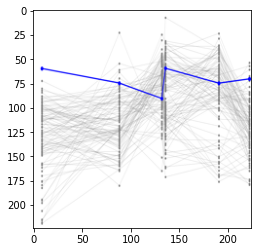

In [105]:
i=random.randrange(len(test_img))
#i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i],  test_cnv_info_df.iloc[i,:])

In [ ]:
print(project_name)
time_stamp = datetime.datetime.now()
time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
print(time_str)

- Confusion matrix

In [141]:
#from sklearn.metrics import classification_report
def show_confusion_matrix(validations, predictions, lables):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4),dpi=150)
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=lables,
                yticklabels=lables,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [136]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}
nClasses = 4

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

Loading CNN_model ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_CNN_model_4classes.h5
Loading MobileNet_v1 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_4classes.h5
Loading ResNet50 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_ResNet50_4classes.h5


In [143]:
test_pred = MobileNet_model.predict(test_img)

In [145]:
test_label

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)


--- Confusion matrix for test data ---

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


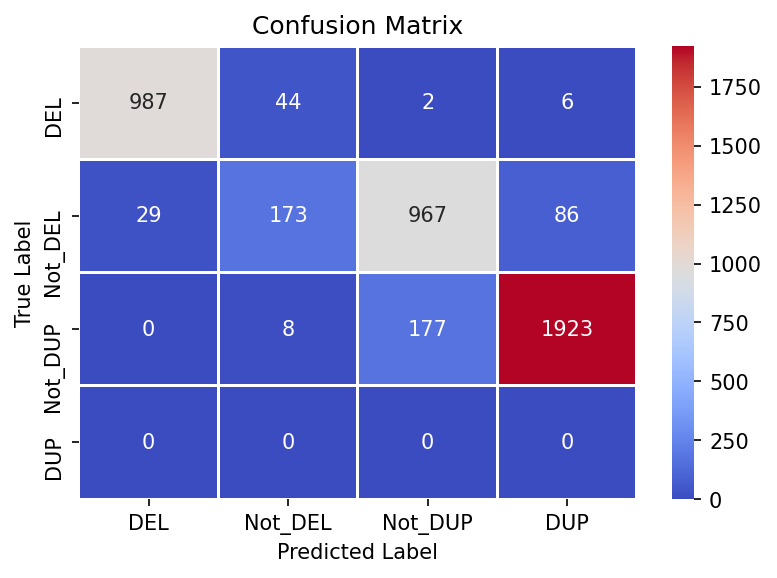


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1039
           1       0.77      0.14      0.23      1255
           2       0.15      0.08      0.11      2108
           3       0.00      0.00      0.00         0

    accuracy                           0.30      4402
   macro avg       0.47      0.29      0.33      4402
weighted avg       0.52      0.30      0.35      4402



/data/rt2776/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/rt2776/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/rt2776/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [142]:
print("\n--- Confusion matrix for test data ---\n")
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
if nClasses == 3:
    labels = ['DEL', 'DIP', 'DUP']
if nClasses == 4:
    labels = ['DEL', 'Not_DEL', 'Not_DUP', 'DUP']
    
test_pred = MobileNet_model.predict(test_img)
# Take the class with the highest probability from the test predictions
max_pred_test = np.argmax(test_pred, axis=1)
max_label_test = np.argmax(test_label, axis=1)
show_confusion_matrix(max_label_test, max_pred_test, labels)

print("\n--- Classification report for test data ---\n")
print(classification_report(max_label_test, max_pred_test))

In [53]:
# output model metrics
model_metric_list = []
model_metric_list.append(model_name)
model_metric_list.append(["loss:", loss]) 
model_metric_list.append(["accuracy:", accuracy])
model_metric_list.append(["precision:", precision])
model_metric_list.append(["recall:", recall])
model_metric_list.append(["f1_score:", f1_score])
output_to_file(model_metric_list, model_dir + "model_metrics_" + model_name + ".txt")

## K-fold cross validation

In [255]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'
model_name='MobileNet_v1'

seed = 6666
num_folds = 5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [256]:
VALIDATION_ACCURACY, VALIDATION_LOSS = [], []
tpr_list, tpr_interp_list, fpr_list, auc_list = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

nClasses = 3

# K-fold Cross Validation model evaluation

train_val_img, test_img, train_val_label, test_label = train_test_split(combined_img,
                                                                      combined_label,
                                                                      test_size=0.2,
                                                                      shuffle=True,
                                                                      random_state=seed)
test_label_one_hot = to_categorical(test_label)

fold_num = 1
for train_index, val_index in kfold.split(train_val_img, train_val_label):
    print('------------------------------------------------------------------------')
    showDateTime()
    print('Training for fold %d ...'%fold_num)
    print("num_index",len(train_index), len(val_index))
   
    train_img  = train_val_img[train_index]
    train_label_one_hot = to_categorical(train_val_label[train_index])
    
    val_img  = train_val_img[val_index]
    val_label_one_hot = to_categorical(train_val_label[val_index])
    
#     train_img, val_img, train_label_one_hot, val_label_one_hot = train_test_split(train_val_img,
#                                                                   train_val_label_one_hot,
#                                                                   test_size=0.25,
#                                                                   shuffle=True,
#                                                                   random_state=seed)
    
    print("Combined:", combined_img.shape, combined_label_one_hot.shape)
    print("Train:", train_img.shape, train_label_one_hot.shape)
    print("Validation:", val_img.shape, val_label_one_hot.shape)
    print("Test:", test_img.shape, test_label_one_hot.shape)
    
    # CREATE and COMPILE NEW MODEL
    model_name='MobileNet_v1'
    print("Model name: %s"%model_name)
    model = cnn_model(model_name, nClasses)
    
    model_file = model_dir + project_name + "_" + model_name + "_fold" +str(fold_num)+".h5"
    
    # CREATE CALLBACKS
    batch_size = 100
    epochs = 50
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = ModelCheckpoint(model_file,
                         monitor='val_accuracy',
                         mode='max', 
                         verbose=1, 
                         save_best_only=True)
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    print("Fit the model ...")
    history = model.fit(train_img, train_label_one_hot,
                        batch_size=batch_size, 
                        epochs=epochs, verbose=1, 
                        validation_data=(val_img, val_label_one_hot), 
                        callbacks=[es, checkpoint])
    ## easy to exhaust the memory by using "validation_split = 0.2"

    # LOAD BEST MODEL to evaluate the performance of the model
    print("Load weights...")
    model.load_weights(model_file)

    print("Evaluate ...")
    results = model.evaluate(test_img, test_label_one_hot)
    results = dict(zip(model.metrics_names,results))
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    fpr_roc, tpr_roc, thresholds_roc, auc_roc = pred_roc_data(model, test_img, test_label_one_hot)    
#     plt.plot(fpr_roc, tpr_roc, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_roc))

    #tpr_list.append(interp(mean_fpr, fpr, tpr))
    interp_tpr = np.interp(mean_fpr, fpr_roc, tpr_roc)
    interp_tpr[0] = 0.0
    
#     print("test data:",test_img.shape, test_label_one_hot.shape)
#     print("tpr, fpr, auc size:",tpr_roc.shape,fpr_roc.shape, auc_roc.shape)
    tpr_list.append(tpr_roc)
    tpr_interp_list.append(interp_tpr)
    fpr_list.append(fpr_roc)
    auc_list.append(auc_roc)
#     print("list size:",len(tpr_list),len(fpr_list), len(auc_list))
    
    tf.keras.backend.clear_session()
    fold_num += 1



------------------------------------------------------------------------
2021.02.09-19:01:10
Training for fold 1 ...
num_index 14084 3522
Combined: (22008, 224, 224, 3) (22008, 3)
Train: (14084, 224, 224, 3) (14084, 3)
Validation: (3522, 224, 224, 3) (3522, 3)
Test: (4402, 224, 224, 3) (4402, 3)
Model name: MobileNet_v1
Fit the model ...
Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8449 - f1_m: 0.7973 - precision_m: 0.8478 - recall_m: 0.7756
Epoch 00001: val_accuracy improved from -inf to 0.79585, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fold1.h5
141/141 [==============================] - 74s 528ms/step - loss: 0.4765 - accuracy: 0.8449 - f1_m: 0.7973 - precision_m: 0.8478 - recall_m: 0.7756 - val_loss: 0.7812 - val_accuracy: 0.7959 - val_f1_m: 0.7964 - val_precision_m: 0.7991 - val_recall_m: 0.7937
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0

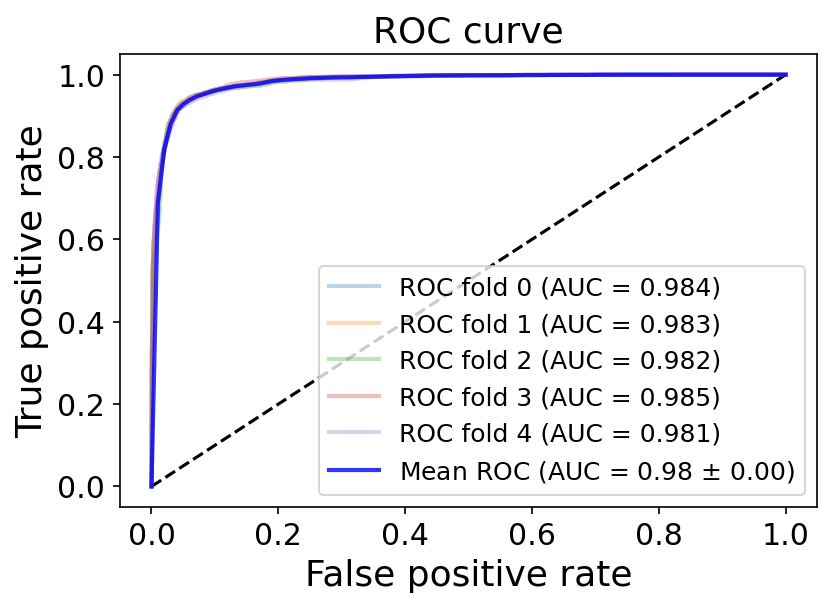

2021.02.09-22:16:25


In [257]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')

for fold_num in range(num_folds):
    plt.plot(fpr_list[fold_num], tpr_list[fold_num], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_list[fold_num]))
    
mean_tpr = np.mean(tpr_interp_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

## plot std
# std_tpr = np.std(tpr_list, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')


plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

    
showDateTime()

In [258]:
image_file = model_dir + project_name + "_" + model_name + "_roc_curve.png"
plt.savefig(image_file)
#plt.close() 

<Figure size 432x288 with 0 Axes>

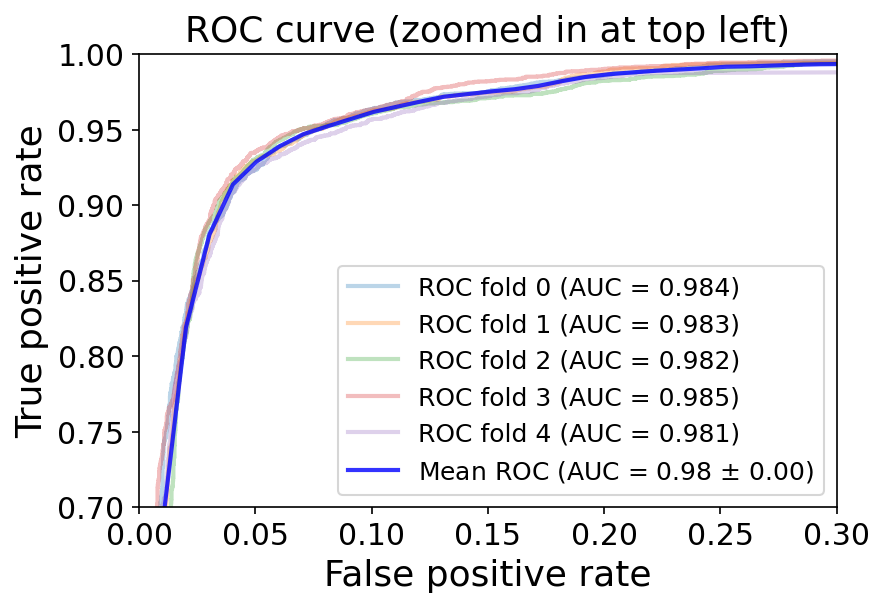

<function matplotlib.pyplot.close(fig=None)>

<Figure size 432x288 with 0 Axes>

In [262]:
plt.figure(2,dpi=150)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')

for fold_num in range(num_folds):
    plt.plot(fpr_list[fold_num], tpr_list[fold_num], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_list[fold_num]))
    
mean_tpr = np.mean(tpr_interp_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
image_zoom_file = model_dir + project_name + "_" + model_name + "_roc_curve_zoom.png"
plt.savefig(image_zoom_file)
plt.close

## Precision

In [ ]:
test_pred = model1.predict(test_img)

In [ ]:
test_output_df = copy.deepcopy(test_cnv_info_df)
test_output_df.shape

In [ ]:
test_output_df.insert(test_output_df.shape[1], 'Prob_True', "")
test_output_df.insert(test_output_df.shape[1], 'Prob_False', "")
test_output_df.insert(test_output_df.shape[1], 'Prediction', "")
test_output_df.insert(test_output_df.shape[1], 'Pred_status', "")

In [ ]:
test_output_df.shape,test_pred.shape, test_cnv_info_df.shape

In [ ]:
num, correct_count = 0, 0
for i in range(len(test_pred)):
    num += 1
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_False')] = test_pred[i][0]
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_True')] = test_pred[i][1]

    if(np.argmax(test_pred[i]) == 0):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Negative"
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Positive"
        
    if(np.argmax(test_pred[i]) == test_label[i]):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Correct"
        correct_count += 1
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Wrong"
#     print(num, test_pred[i], test_label[i], pred_status)
score = correct_count/len(test_pred)
print('Accuracy for testing data: %.2f%s' % (score*100,'%'))

In [ ]:
## output to file
output_path = '/home/rt2776/cnv_espresso/output/'
test_output_df.to_csv(output_path+project_name+'_test_predict_info.csv',index=False)


In [ ]:
test_output_df[test_output_df['Pred_status']=='Wrong']

In [ ]:
test_output_df.index=range(len(test_output_df))

In [ ]:
#i=random.randrange(len(test_img))
i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i], test_pred[i],  test_output_df.iloc[i,:])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
- F1 score: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model